# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**__Reiley Reed__________

**Worked with:**_Sofia Guo, Stacy Chen, Marisa Tsai, Neena Albarus 

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2023-12-15 10:02:28.370391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 10:02:28.488268: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 10:02:28.492431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-15 10:02:28.492447: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

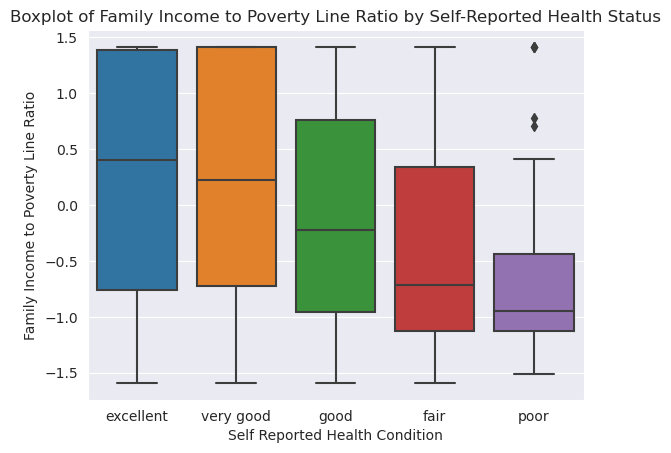

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

In [4]:
print(nhanes_scaled.HSD010)

SEQN
73568    excellent
73576    excellent
73579    very good
73581    very good
73584         good
           ...    
83694         good
83696    very good
83704         fair
83716    excellent
83721    very good
Name: HSD010, Length: 2064, dtype: object


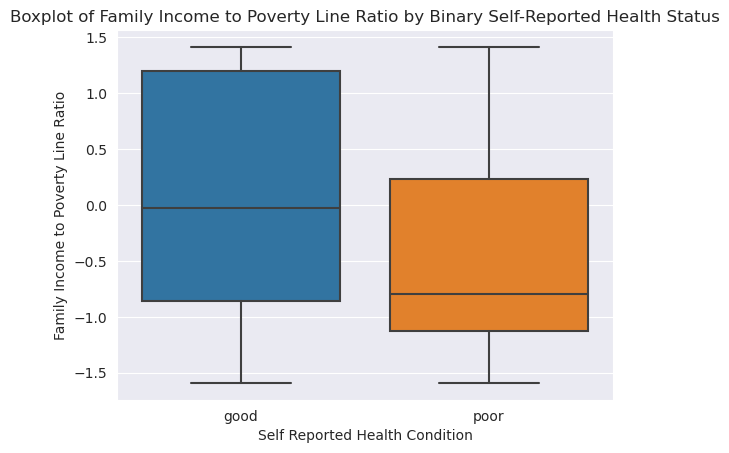

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

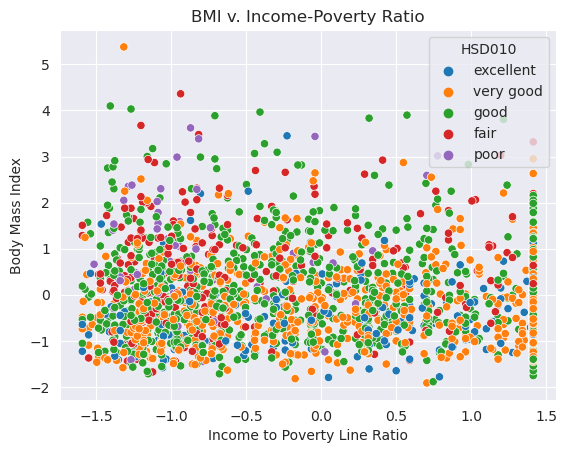

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)

In [9]:
pca_df = pd.DataFrame(data = principalComponents_nhanes_scaled
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

I decided to include three PCA components here to start because I wanted to choose a number between 1 and the total number of potential components. Next I will check to see how much additional variation would be explained by adding additional components to decide if three is appropriate.  

In [10]:
pca_df.head()

,principal component 1,principal component 2,principal component 3
0,9.527812,-0.816216,-1.867177
1,-5.838339,-3.692576,3.805814
2,-0.719455,-2.573199,0.907900
3,3.533627,-2.576988,-3.249017
4,-6.872094,-4.194233,0.886754


### Barplot of Components

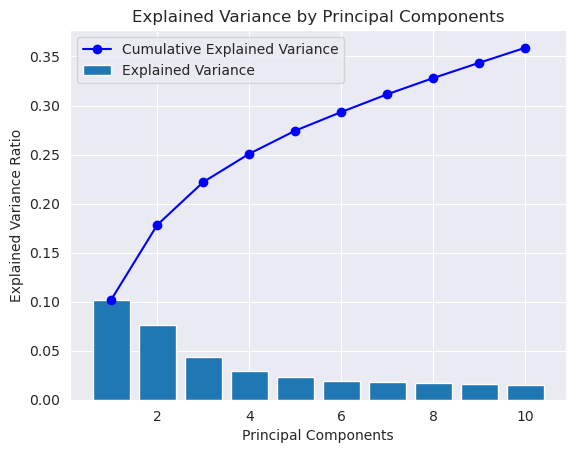

In [11]:
pca = PCA(n_components=10)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Barplot of the explained variance for each component
plt.bar(range(1, len(cumulative_explained_variance) + 1), pca.explained_variance_ratio_, label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label='Cumulative Explained Variance', marker='o', color='blue')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()

### How many components will you use to fit a supervised learning model?

I will include 5 components, given that, as shown in the bar graph above, after 5 components the explained variance ratio seems to level off with each additional component. 

### 2D Scatterplot of the first two components

In [12]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')

In [13]:
nhanes_scaled['HSD010'] 

SEQN
73568    1
73576    1
73579    2
73581    2
73584    3
        ..
83694    3
83696    2
83704    4
83716    1
83721    2
Name: HSD010, Length: 2064, dtype: int64

In [14]:
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010

In [15]:
#checking that appropriate variables are in the datasets
nhanes_scaled_columns = nhanes_scaled.columns
print("Column names of nhanes_scaled:", nhanes_scaled_columns)

pca_df_columns = pca_df.columns
print("Column names of pca_df:", pca_df_columns)

Column names of nhanes_scaled: Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874', 'SMQ878',
       'SMAQUEX.x', 'HSD010', 'SEQN'],
      dtype='object', length=243)
Column names of pca_df: Index(['principal component 1', 'principal component 2',
       'principal component 3'],
      dtype='object')


In [16]:
print(hsd010)

0       1
1       1
2       2
3       2
4       3
       ..
2059    3
2060    2
2061    4
2062    1
2063    2
Name: HSD010, Length: 2064, dtype: int64


In [17]:
hsd010 = hsd010.replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
print(hsd010)

0       excellent
1       excellent
2       very good
3       very good
4            good
          ...    
2059         good
2060    very good
2061         fair
2062    excellent
2063    very good
Name: HSD010, Length: 2064, dtype: object


<Figure size 640x480 with 0 Axes>

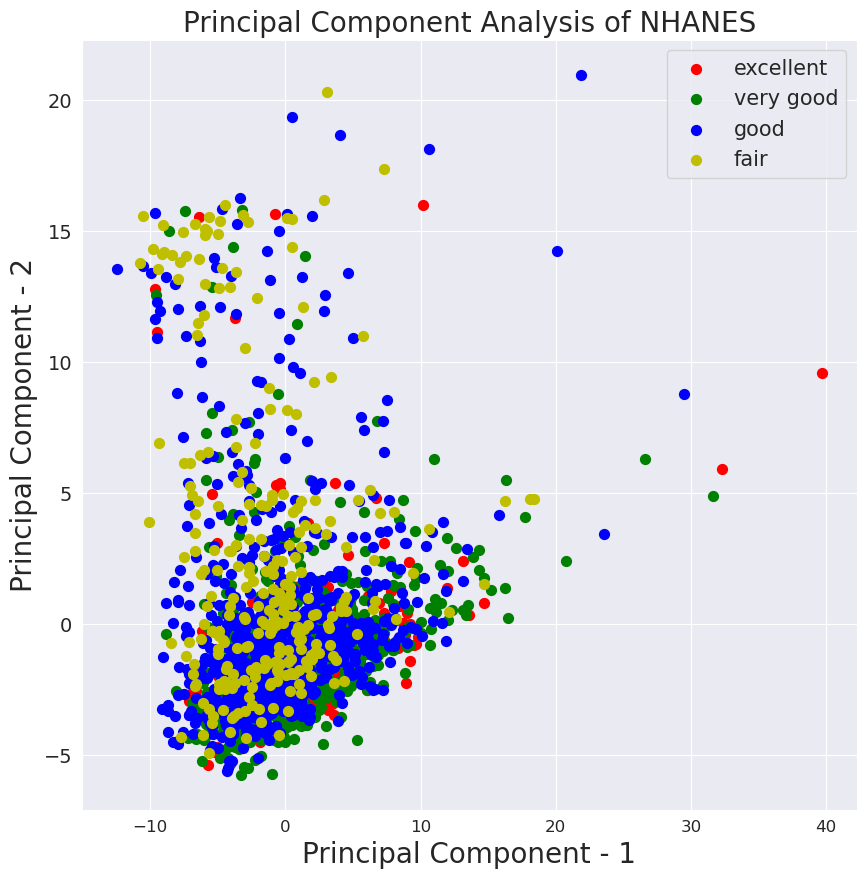

In [18]:
# plot
# ----------


# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES",fontsize=20)
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b', 'y']


# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = hsd010 == target
    indicesToKeep = indicesToKeep.reset_index(drop=True) #had to add this line
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();


Given that one of the primary applications of PCA is to reduce dimensionality of data, in the plot above, it is important to examine the extent to which there are any significant patterns or groupings of data points. There does not appear that there is any clear pattern, which supports the decision to include 5 components (more than three). 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I will use the k-means algorithm, given that it is particularly helpful for identifing natural groups or clusters, which will support with identifying trends and patterns, as well as outliers in the data.  

In [19]:
# load libraries 
# ----------
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# settings
%matplotlib inline

In [20]:
# set random seed
np.random.seed(10)

In [21]:
#reimporting data, scaling, w/out changing target variable to string

# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
#nhanes_scaled.head()

In [22]:
X=nhanes_scaled

In [23]:
df = pd.DataFrame(X)

nhanes_scaled_columns = X.columns
print("Column names of nhanes_scaled:", nhanes_scaled_columns)

Column names of nhanes_scaled: Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ770', 'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874',
       'SMQ878', 'SMAQUEX.x', 'HSD010'],
      dtype='object', length=242)


In [24]:
# Keep only two variables (columns)
selected_columns = ["INDFMPIR", "BMXBMI"]
df_subset = df[selected_columns]

# Display the resulting DataFrame
print(df_subset)

X=df_subset

       INDFMPIR    BMXBMI
SEQN                     
73568  1.412214 -1.001972
73576 -0.642017 -0.618783
73579  0.192890 -1.636215
73581  1.412214 -0.565929
73584  0.252955 -0.341301
...         ...       ...
83694  0.343053 -0.341301
83696 -1.092507  0.081527
83704 -1.591048  1.508575
83716  0.589320 -0.499862
83721  1.412214 -0.301661

[2064 rows x 2 columns]


In [25]:
array_representation =X.values
array_representation

array([[ 1.41221429, -1.00197156],
       [-0.64201717, -0.61878288],
       [ 0.19288976, -1.63621489],
       ...,
       [-1.59104808,  1.50857496],
       [ 0.5893204 , -0.49986226],
       [ 1.41221429, -0.30166122]])

### Cluster nhanes

In [26]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(array_representation)


Given that we are using k-means clustering, we set the number of clusters, which then reduces differences within each cluster. This process occues by randomly assigning each value to a cluster, caluculating each cluster mean, and then iteratively reassigning each value the cluster based on the mean values of data points within each cluster. 

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

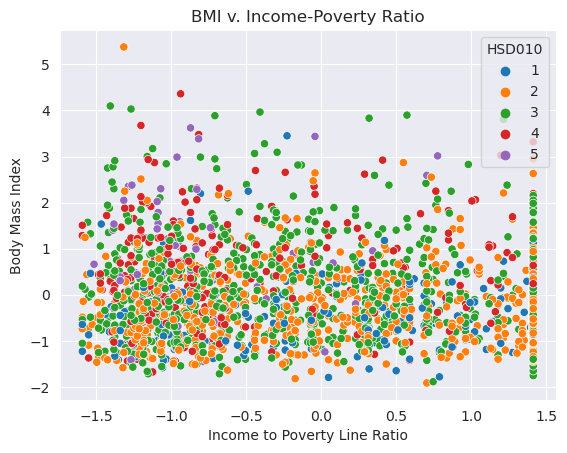

In [27]:
# without clusters

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()


Most of the data is found between -1 to 1 BMI. Additionally, there appears to be slightly more dense clusters below the poverty line compared to above it. Most importantly, overall, there doesn't seem to be a very clear relationship between perceived health status and BMI and income. 

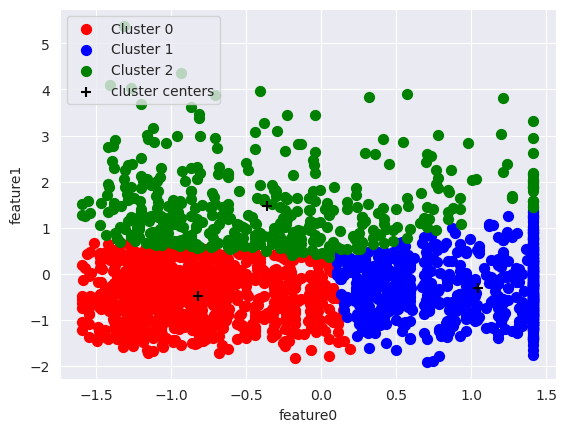

In [28]:
# with clusters
# figure settings
fig = plt.figure()
ax1 = fig.add_subplot(111)

# plot
ax1.scatter(*array_representation[kmeans.labels_==0,:].T, s=50, c='r', label='Cluster 0')
ax1.scatter(*array_representation[kmeans.labels_==1,:].T, s=50, c='b', label='Cluster 1')
ax1.scatter(*array_representation[kmeans.labels_==2,:].T, s=50, c='g', label='Cluster 2')
ax1.scatter(*kmeans.cluster_centers_.T, s=50, marker='+', c='black', label='cluster centers')
plt.legend(loc='upper left')
plt.xlabel('feature0')
plt.ylabel('feature1')
plt.show()

In the figure above there is a clear pattern, which indicates that the cluster assignments are appropriately described by the PCA-reduced features.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [29]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(pca_df)

In [30]:

# print the centers 
print("Centers")
print(kmeans.cluster_centers_)
print()

# print labels
print("Labels")
print(kmeans.labels_)
print()

# print coordinates and labels 
for point, label in zip(pca_df, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)
    

Centers
[[ 5.94835988  0.30929564  0.13266658]
 [-4.0907595  10.88608924 -1.4003823 ]
 [-1.93810875 -1.66469664  0.14124481]]

Labels
[0 2 2 ... 2 0 2]

Coordinates: principal component 1 Label: 0
Coordinates: principal component 2 Label: 2
Coordinates: principal component 3 Label: 2


## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [31]:
import numpy as np
import tensorflow as tf

# Example NumPy array
np_array = np.array([[1.0, 2.0, 3.0],
                     [4.0, 5.0, 6.0]])

# Convert NumPy array to TensorFlow tensor
tf_tensor = tf.convert_to_tensor(np_array, dtype=tf.float32)


2023-12-15 10:02:34.247840: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-15 10:02:34.247864: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-15 10:02:34.247881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-reireed): /proc/driver/nvidia/version does not exist
2023-12-15 10:02:34.248273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
nhanes_scaled =nhanes_scaled.drop(['HSD010'], axis = 1) # drop out any columns that aren't features
#SEQN already dropped

In [33]:
X=nhanes_scaled

In [34]:
y.shape

(2064,)

In [35]:
y

0       1
1       1
2       2
3       2
4       3
       ..
2059    3
2060    2
2061    4
2062    1
2063    2
Name: HSD010, Length: 2064, dtype: int64

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [37]:
y_train.shape

(1548,)

In [38]:
y_train

604     1
1907    2
1487    4
899     1
494     3
       ..
2009    2
1180    3
1344    2
527     3
1289    4
Name: HSD010, Length: 1548, dtype: int64

In [39]:
y_test

85      2
1762    3
1002    2
1339    1
1699    3
       ..
2026    2
803     3
1377    2
550     2
126     2
Name: HSD010, Length: 516, dtype: int64

In [40]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [41]:
# create neural network model
# -----------
model = Sequential()

#y_train [1]= categories in outcome variable
#x_train[1] = # of features in data
model.add(Dense(y_train.shape[1], input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here


model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

#fit to training data
# this line is what needs to be changed for the next two questions
#model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=2)

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross va

Epoch 1/10
8/8 - 1s - loss: 2.2953 - accuracy: 0.0904 - val_loss: 2.2722 - val_accuracy: 0.1725 - 692ms/epoch - 87ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2438 - accuracy: 0.2416 - val_loss: 2.2197 - val_accuracy: 0.3043 - 36ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 2.1842 - accuracy: 0.3430 - val_loss: 2.1572 - val_accuracy: 0.3547 - 34ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 2.1120 - accuracy: 0.3882 - val_loss: 2.0791 - val_accuracy: 0.3779 - 34ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 2.0242 - accuracy: 0.4089 - val_loss: 1.9859 - val_accuracy: 0.4089 - 34ms/epoch - 4ms/step
Epoch 6/10
8/8 - 0s - loss: 1.9228 - accuracy: 0.4251 - val_loss: 1.8828 - val_accuracy: 0.4147 - 33ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 1.8166 - accuracy: 0.4302 - val_loss: 1.7772 - val_accuracy: 0.4186 - 35ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 1.7129 - accuracy: 0.4438 - val_loss: 1.6771 - val_accuracy: 0.4225 - 33ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 1.6175 - a

### Neural Network on Principal Components

In [42]:
y = hsd010

In [43]:
y.shape

(2064,)

In [44]:
X=pca_df

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [46]:
y_train.shape

(1548,)

In [47]:
y

0       1
1       1
2       2
3       2
4       3
       ..
2059    3
2060    2
2061    4
2062    1
2063    2
Name: HSD010, Length: 2064, dtype: int64

In [48]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]


In [49]:
# create neural network model
# -----------
model = Sequential()

#y_train [1]= categories in outcome variable
#x_train[1] = # of features in data
model.add(Dense(y_train.shape[1], input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here


model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

#fit to training data
# this line is what needs to be changed for the next two questions
#model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=2)

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 1s - loss: 2.2658 - accuracy: 0.3443 - val_loss: 2.2495 - val_accuracy: 0.3857 - 553ms/epoch - 69ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2388 - accuracy: 0.3876 - val_loss: 2.2215 - val_accuracy: 0.4070 - 32ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2092 - accuracy: 0.3947 - val_loss: 2.1903 - val_accuracy: 0.4128 - 31ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 2.1760 - accuracy: 0.4050 - val_loss: 2.1554 - val_accuracy: 0.4225 - 32ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 2.1389 - accuracy: 0.4044 - val_loss: 2.1166 - val_accuracy: 0.4186 - 32ms/epoch - 4ms/step
Epoch 6/10
8/8 - 0s - loss: 2.0977 - accuracy: 0.4096 - val_loss: 2.0738 - val_accuracy: 0.4225 - 31ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 2.0525 - accuracy: 0.4089 - val_loss: 2.0270 - val_accuracy: 0.4186 - 32ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 2.0038 - accuracy: 0.4141 - val_loss: 1.9770 - val_accuracy: 0.4205 - 33ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 1.9520 - a

In [50]:
y_train.shape

(1548, 10)

### Neural Network on Principal Components + Cluster Membership

In [51]:
y = hsd010

In [52]:
X=array_representation

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [54]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [55]:
# create neural network model
# -----------
model = Sequential()

#y_train [1]= categories in outcome variable
#x_train[1] = # of features in data
model.add(Dense(y_train.shape[1], input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here


model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

#fit to training data
# this line is what needs to be changed for the next two questions
#model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=2)

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 1s - loss: 2.2975 - accuracy: 0.2048 - val_loss: 2.2903 - val_accuracy: 0.3043 - 543ms/epoch - 68ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2852 - accuracy: 0.3327 - val_loss: 2.2779 - val_accuracy: 0.3236 - 33ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2726 - accuracy: 0.3450 - val_loss: 2.2648 - val_accuracy: 0.3333 - 34ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 2.2591 - accuracy: 0.3792 - val_loss: 2.2502 - val_accuracy: 0.3547 - 32ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 2.2439 - accuracy: 0.3992 - val_loss: 2.2337 - val_accuracy: 0.3837 - 32ms/epoch - 4ms/step
Epoch 6/10
8/8 - 0s - loss: 2.2262 - accuracy: 0.4128 - val_loss: 2.2145 - val_accuracy: 0.3876 - 32ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 2.2056 - accuracy: 0.4186 - val_loss: 2.1920 - val_accuracy: 0.4031 - 32ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 2.1814 - accuracy: 0.4193 - val_loss: 2.1659 - val_accuracy: 0.4070 - 32ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 2.1538 - a

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA and clustering differ in terms of application, process and output. While PCA is typically used for feature and noise reduction, as well as visualization, clustering is more often used in the context of identifying patterns in the data. PCA creates a set of transformed variables that are created and ordered based on the variance of the features of the original data. However, clustering groups variables together based on how similar they are. Another slight difference is that PCA is typically an unsupervised technique vs clustering can be used in both supervised or unsupervised contexts (though it's very frequently used in unsupervised contexts). 

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

There do appear to be some advantages to combining PCA and clustering. I noticed that the plot created prior to PCA did not reveal any clear relationship, patterns or trends in the data. However, after running PCA, there did appear to be a pattern/relationship in the data, which demonstrates the utility of combining PCA and clustering.   

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

 Different types of unsupervised techniques can help with increasing the efficiency of downstream supervised learning tasks. For example, as noted above, PCA can help reduce dimensionality and noise, which is particularly helpful in very large datasets that have many features. This has the potential to increase the efficiency of downstream supervised learning tasks as it highlights the most salient data and removes the more extraneous data. Clustering similarly can increase the efficiency of downstream supervised learning tasks as it supports with identifying patterns and/or grouping the data. This can support supervised algorithms to find patterns as well, which allows for increased efficiency in supervised machine learning techniques.  